# Requirements

In [1]:
using Plots

# Problem setting

The following iterations is considered: $z_{n+1} = z_n^2 + c$ where $z$ and $c$ are complex numbers. The iteration is stopped either when $|z| \ge 2$ or $n > 255$.  The domain is a square in the complex plane centered around the origin. $c$ is a constant.

The following function computes $n$ for a given value of $z$ and $c$.

In [2]:
function iterate(z::ComplexF64, c::ComplexF64)::UInt8
    n::UInt8 = 0
    while n < 255 && abs(z) < 2.0
        z = z^2 + c
        n += 1
    end
    return n
end

iterate (generic function with 1 method)

The following function creates a tile in the complex plane with $z$ as the upper-left corner, $n$ values along the real and imaginary axes, spaced $\delta$ apart..

In [3]:
function make_tile(z::ComplexF64, δ::Float64, n::Int64)::Array{ComplexF64}
    z_real = real(z):δ:(real(z) + (n - 1)*δ)
    z_real = z_real' .* ones(n)
    z_imag = imag(z):δ:(imag(z) + (n - 1)*δ)
    z_imag = z_imag' .* ones(n)
    return z_real' + 1.0im*z_imag
end

make_tile (generic function with 1 method)

In [4]:
make_tile(1.0 + 2.0im, 0.1, 5)

5×5 Matrix{ComplexF64}:
 1.0+2.0im  1.0+2.1im  1.0+2.2im  1.0+2.3im  1.0+2.4im
 1.1+2.0im  1.1+2.1im  1.1+2.2im  1.1+2.3im  1.1+2.4im
 1.2+2.0im  1.2+2.1im  1.2+2.2im  1.2+2.3im  1.2+2.4im
 1.3+2.0im  1.3+2.1im  1.3+2.2im  1.3+2.3im  1.3+2.4im
 1.4+2.0im  1.4+2.1im  1.4+2.2im  1.4+2.3im  1.4+2.4im

The function `compute_tile` creates a tile, and applies the `iterate` function to it, returning a 2D array of unsigned integer values corresponding to the number of iterations for the points in the complex plane.

In [4]:
function compute_tile(z::ComplexF64, δ::Float64, n::Int64, c::ComplexF64)::Array{UInt8}
    tile = make_tile(z, δ, n)
    return iterate.(tile, c)
end

compute_tile (generic function with 1 method)

In [6]:
compute_tile(0.0 + 0.0im, 0.1, 5, 0.4 + 0.6im)

5×5 Matrix{UInt8}:
 0x0f  0x0c  0x16  0x0f  0x12
 0x0f  0x0b  0x11  0x0a  0x09
 0x07  0x07  0x0e  0x07  0x07
 0x05  0x05  0x05  0x05  0x05
 0x04  0x04  0x04  0x04  0x04

To tile the complete domain, the function `make_domain` computes the upper-left corner of each tile in the square domain defined by $-z$ (lower-left corner) an $z$ (upper-right corner) and the number of tiles.

In [5]:
function make_domain(z::ComplexF64, nr_tiles::Int64)::Array{ComplexF64}
    if nr_tiles > 1
        δ = 2.0*real(z)/nr_tiles
        return make_tile(-z, δ, nr_tiles)
    else
        domain = Array{ComplexF64}(undef, 1, 1)
        domain[1, 1] = -z
        return domain
    end
end

make_domain (generic function with 1 method)

In [8]:
make_domain(1.8  + 1.8im, 5)

5×5 Matrix{ComplexF64}:
  -1.8-1.8im   -1.8-1.08im   -1.8-0.36im   -1.8+0.36im   -1.8+1.08im
 -1.08-1.8im  -1.08-1.08im  -1.08-0.36im  -1.08+0.36im  -1.08+1.08im
 -0.36-1.8im  -0.36-1.08im  -0.36-0.36im  -0.36+0.36im  -0.36+1.08im
  0.36-1.8im   0.36-1.08im   0.36-0.36im   0.36+0.36im   0.36+1.08im
  1.08-1.8im   1.08-1.08im   1.08-0.36im   1.08+0.36im   1.08+1.08im

The function `compute_domain` brings it all together. $z$ defines the square domain to operate on. $c$ is the complex constant, $n$ the number of points on the real and imaginary axis, and $nr_{tiles}$ the number of tiles along the real and imaginary axes.

In [6]:
function compute_domain(z::ComplexF64, c::ComplexF64, n::Int64, nr_tiles::Int64)::Array{UInt8}
    tile_size = n ÷ nr_tiles
    δ = 2.0*real(z)/n
    result = Array{UInt8}(undef, n, n)
    domain = make_domain(z, nr_tiles)
    for i in 1:nr_tiles
        i_min = 1 + (i - 1)*tile_size
        i_range = i_min:(i_min + tile_size - 1)
        for j in 1:nr_tiles
            j_min = 1 + (j - 1)*tile_size
            j_range = j_min:(j_min + tile_size - 1)
            result[i_range, j_range] = compute_tile(domain[i, j], δ, tile_size, c)
        end
    end
    return result
end

compute_domain (generic function with 1 method)

# Plots

And of course, you get nice plots.

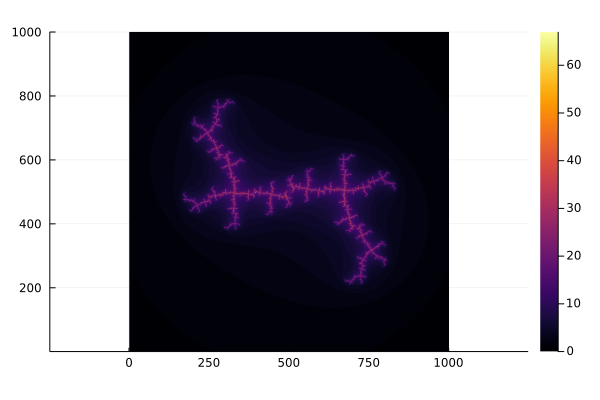

In [10]:
heatmap(compute_domain(1.8 + 1.8im, 0.4 + 0.6im, 1000, 1), aspect_ratio=:equal)

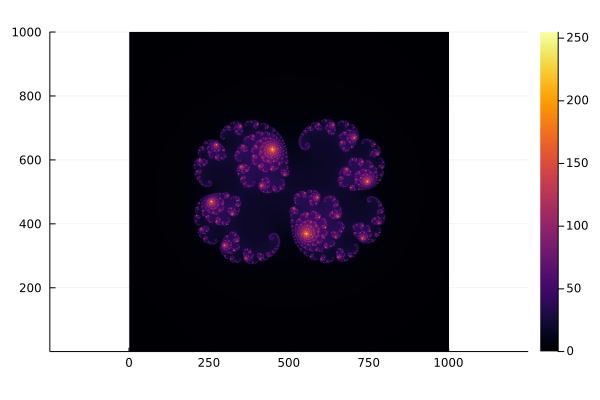

In [11]:
heatmap(compute_domain(1.8 + 1.8im, 0.285 - 0.01im, 1000, 1), aspect_ratio=:equal)

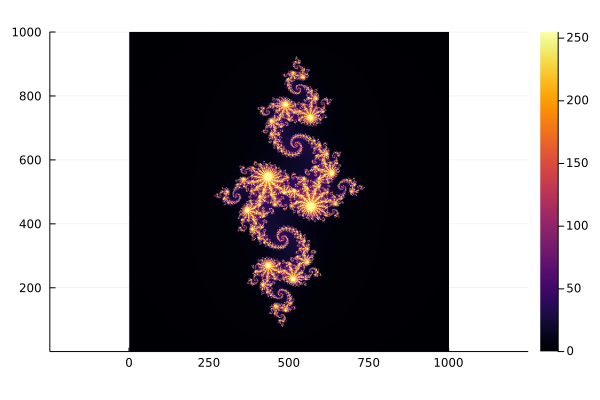

In [12]:
heatmap(compute_domain(1.8 + 1.8im, -0.8 - 0.156im, 1000, 1), aspect_ratio=:equal)

# Performance

In [1]:
using BenchmarkTools

In [8]:
@benchmark compute_domain(1.8 + 1.8im, 0.4 + 0.6im, 1000, 1)

BechmarkTools.Trial: 105 samples with 1 evaluations.
 Range (min … max):  43.746 ms … 99.819 ms  ┊ GC (min … max): 4.48% … 57.87%
 Time  (median):     46.386 ms              ┊ GC (median):    2.05%
 Time  (mean ± σ):   47.994 ms ±  7.155 ms  ┊ GC (mean ± σ):  5.51% ±  7.35%

  ▁▆   █                                                       
  ███▇▃█▃▅▇▃▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  43.7 ms         Histogram: frequency by time          92 ms <

 Memory estimate: 47.70 MiB, allocs estimate: 15.

In [9]:
@benchmark compute_domain(1.8 + 1.8im, 0.4 + 0.6im, 3000, 1)

BechmarkTools.Trial: 10 samples with 1 evaluations.
 Range (min … max):  498.189 ms … 645.997 ms  ┊ GC (min … max): 2.63% … 19.94%
 Time  (median):     537.175 ms               ┊ GC (median):    4.07%
 Time  (mean ± σ):   545.434 ms ±  44.178 ms  ┊ GC (mean ± σ):  7.84% ±  5.78%

  █   ▁          █▁  ▁       ▁     ▁                          ▁▁ 
  █▁▁▁█▁▁▁▁▁▁▁▁▁▁██▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  498 ms           Histogram: frequency by time          646 ms <

 Memory estimate: 429.20 MiB, allocs estimate: 17.